# Bitcoin Price Prediction Project with ARIMA, XGBoost and LSTM
## XGBoost

This notebook is part of Bitcoin Price Prediction Project with XGBoost model.
Complete project consists of three notebooks with sections as below.

1. Abstract
2. Data description   # (01_BTC_Price_Prediction - ARIMA.ipynb notebook)
3. Gathering data     # (01_BTC_Price_Prediction - ARIMA.ipynb notebook)
4. Data preprocessing
5. ARIMA Model        # (01_BTC_Price_Prediction - ARIMA.ipynb notebook)
    - 5.1. ARIMA  =>  Introduction
    - 5.2. ARIMA Model  =>  function definition
    - 5.3. ARIMA Model  =>  Forecasting
        - complete data
        - data start from 2018-01-01
        - data start from 2021-01-01
    - 5.4. ARIMA Model  =>  summary
6. XGBoost            # (this notebook)
    - 6.1. XGBRegressor  =>  Introduction
    - 6.2. XGBRegressor  =>  function definition
    - 6.3. XGBRegressor  =>  Forecasting
        - complete data
        - data start from 2018-01-01
        - data start from 2021-01-01
    - 6.4. XGBRegressor  =>  summary
7. LSTM Model         # (03_BTC_Price_Prediction - LSTM.ipynb notebook)
    - 7.1. LSTM  =>  Introduction
    - 7.2. LSTM  =>  function definition
    - 7.3. LSTM  =>  Forecasting
        - complete data
        - data start from 2018-01-01
        - data start from 2021-01-01
    - 7.4. LSTM  =>  summary
8. Project summary    # (03_BTC_Price_Prediction - LSTM.ipynb notebook)

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, date

import matplotlib.pyplot as plt

from tqdm import tqdm

## 4. Data preprocessing

In [2]:
# restore data backup
btc_df_gathered = pd.read_csv("BTC_Preprocess_Backup.csv", sep = ",", skipinitialspace=True)
btc_df_gathered.head()

,time_open,time_close,open,high,low,close,market_cap,volume
0,2010-07-17T00:00:00Z,2010-07-17T23:59:59Z,0.04951,0.04951,0.04951,0.04951,NaN,NaN
1,2010-07-18T00:00:00Z,2010-07-18T23:59:59Z,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2,2010-07-19T00:00:00Z,2010-07-19T23:59:59Z,0.08584,0.08584,0.08584,0.08584,NaN,NaN
3,2010-07-20T00:00:00Z,2010-07-20T23:59:59Z,0.08080,0.08080,0.08080,0.08080,NaN,NaN
4,2010-07-21T00:00:00Z,2010-07-21T23:59:59Z,0.07474,0.07474,0.07474,0.07474,NaN,NaN


In [3]:
# copy data to new df
btc_df_1 = btc_df_gathered

In [4]:
# check datatypes
btc_df_1.dtypes

time_open      object
time_close     object
open          float64
high          float64
low           float64
close         float64
market_cap    float64
volume        float64
dtype: object

In [5]:
# change df index to date
btc_df_1.index = pd.to_datetime(btc_df_1["time_close"]).dt.date

# drop "time_open", "time_close" columns
btc_df_1.drop(["time_open", "time_close"], axis=1, inplace=True)
btc_df_1.head()

,open,high,low,close,market_cap,volume
time_close,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2010-07-18,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2010-07-19,0.08584,0.08584,0.08584,0.08584,NaN,NaN
2010-07-20,0.08080,0.08080,0.08080,0.08080,NaN,NaN
2010-07-21,0.07474,0.07474,0.07474,0.07474,NaN,NaN


In [6]:
# show df shape
btc_df_1.shape

(4276, 6)

In [7]:
btc_df_1.describe()

,open,high,low,close,market_cap,volume
count,4276.000000,4276.000000,4276.000000,4276.000000,3.260000e+03,3.017000e+03
mean,7620.722003,7818.648308,7411.105750,7632.136514,1.835636e+11,1.205864e+10
std,14287.143745,14651.680612,13896.018691,14300.996427,2.947438e+11,1.710047e+10
min,0.049510,0.049510,0.049510,0.049510,7.784112e+08,2.857830e+06
25%,111.217500,114.591000,107.450000,111.500000,6.510601e+09,5.567090e+07
50%,638.137000,656.522000,627.096000,638.393000,6.466303e+10,3.682395e+09
75%,8191.225324,8321.616465,7952.276240,8196.622730,1.752686e+11,1.885380e+10
max,67589.872823,68692.137037,66457.970074,67589.768671,1.275266e+12,1.363702e+11


## 6. XGBoost

## 6.1. XGBRegressor  =>  Introduction

This notebook was created to predict the Bitcoin price (in USD) using the XGBoost model.
The model has been programmed in a function to perform a forecast with different data ranges. 
To evaluate optimal parameters, GridSearchCV was used.

The mean square error (RMSE) was used to evaluate the performance of the model - it should be as low as possible.

Training data is the first 80% of the dataset and the rest is in the test datasets.

At the end of the notebook, a summary of the task is presented along with a graph of the RMSE results of the model.

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

GridSearchCV - automatically estimate the optimal parameters by cross-validated grid-search over a parameter grid

For price prediction it will be used "market_cap", "volume" df columns and "time_close" as idex.

In [8]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

from xgboost.sklearn import XGBRegressor

### 6.2. XGBRegressor  =>  function definition

In [9]:
def xgbregressor_variants(df_variants: list, train_size: float):
    
    """
    This function includes XGBRegressor modeling for Bitcoin price prediction with GridSearchCV
    to find optimal model parameters.
    The function is prepared for prediction, based on a sets of data - eg. different ranges of historical data.
    """
    
    variant = 0  # data variant number
    rmse = []    # XGBRegressor rmse
    
    # general loop fo data viaraints (data range)
    for df in tqdm(df_variants):
        
        # ---------------------------------------------------------------
        # increment for data variant number
        variant = variant + 1
        print(f"\nData variant no:", variant, "\n")
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # define X and y
        X = df[["market_cap", "volume"]]
        y = df["close"]
        print(f"Length of X={len(X)},", f"\nLength of y={len(y)}")

        # train, test, split the data
        # train = train_size * data(X)
        # test  = train_size * data(y)
        size = int(len(X) * train_size)
        X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # evauating best params for XGBRegressor and gscv.fit
        print("\nXGBRegressor fit, predict with GridSearchCV:")
        
        model = XGBRegressor(objective ="reg:squarederror",
                             booster="gbtree",      # Specify which booster to use: gbtree, gblinear or dart.
                             subsample=0.9,         # Subsample ratio of the training instance.
                             colsample_bytree=0.5)  # Subsample ratio of columns when constructing each tree.

        param_grid = {
            "n_estimators": [1, 2, 5, 10, 20],                    # Number of gradient boosted trees. 
                                                                  # Equivalent to number of boosting rounds.
            "reg_lambda": [0.000001, 0.00001, 0.0001, 0.001],     # L2 regularization term on weights (xgb's lambda).
            "learning_rate": [0.8, 1.0, 1.2, 1.4],                # Boosting learning rate (xgb's "eta")
            "max_depth": [2, 5, 10, 15, 30, 60, 90],              # Maximum tree depth for base learners.
            "min_child_weight": [0.0000000000001, 0.000000000001] # Minimum sum of instance weight (hessian) needed in a child.
        }

        gscv = GridSearchCV(model, 
                            param_grid=param_grid, 
                            cv=10, 
                            scoring="neg_mean_squared_error")

        gscv.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=False,
                 early_stopping_rounds=20)

        y_pred = gscv.best_estimator_.predict(X_test)
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # show best params
        print("\nBest params:\n", gscv.best_params_)
        
        # show best estimator
        print("\nBest estimator:\n", gscv.best_estimator_)
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------        
        # plot training losses
        training_losses = gscv.best_estimator_.evals_result()
        optimal_tree = gscv.best_estimator_.best_ntree_limit
        print(f"optimal trees: {optimal_tree}")

        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(training_losses["validation_0"]["rmse"], "green", label="Training loss")
        plt.plot(training_losses["validation_1"]["rmse"], "blue", label="Test loss")
        plt.axvline(optimal_tree, color="gray", label="Optimal tree number")
        plt.title("Training losses")
        plt.xlabel("Number of trees")
        plt.ylabel("Loss")
        plt.legend(loc="best", fontsize=8)
        plt.show()
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # plot results with train data
        fore_series = pd.Series(y_pred, index=X_test.index)

        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(y_train, "green", label="Train data")
        plt.plot(y_test, "blue", label="Actual Price/ Test data")
        plt.plot(fore_series, "orange", label="Predicted Price")

        plt.title("BTC Price Prediction - with forecast")
        plt.xlabel("Time")
        plt.ylabel("BTC Price")
        plt.legend(loc="best", fontsize=8)
        plt.show()
        
        # plot results predictions and test data - zoom-in results
        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(y_test, "blue", label="Actual Price/ Test data")
        plt.plot(fore_series, "orange", label="Predicted Price")

        plt.title("BTC Price Prediction - with forecast")
        plt.xlabel("Time")
        plt.ylabel("BTC Price")
        plt.legend(loc="best", fontsize=8)
        plt.show()
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # print performance
        rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
        print(model.__class__.__name__, "variant", variant,":", "RMSE = %.3f" % rmse_1, "\n")
        rmse.append(float(format(rmse_1, ".3f")))
        # ---------------------------------------------------------------
        
    # end of general loop for data viaraints (data range)
        
    return rmse

### 6.3. XGBRegressor  =>  Forecasting

In [10]:
# copy full dataset
df_var_1 = btc_df_1.fillna(0)

# copy data starting from 2018-01-01 and replace NaN values to 0
df_var_2 = btc_df_1.fillna(0).iloc[2725:]

# copy data starting from 2021-01-01 and replace NaN values to 0
df_var_3 = btc_df_1.fillna(0).iloc[3821:]

data_variants = [
    df_var_1, 
    df_var_2,
    df_var_3
]

  0%|          | 0/3 [00:00<?, ?it/s]


Data variant no: 1 

Length of X=4276, 
Length of y=4276

XGBRegressor fit, predict with GridSearchCV:

Best params:
 {'learning_rate': 1.0, 'max_depth': 90, 'min_child_weight': 1e-13, 'n_estimators': 5, 'reg_lambda': 0.0001}

Best estimator:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=1.0, max_delta_step=0,
             max_depth=90, min_child_weight=1e-13, missing=nan,
             monotone_constraints='()', n_estimators=5, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.0001, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)
optimal trees: 4


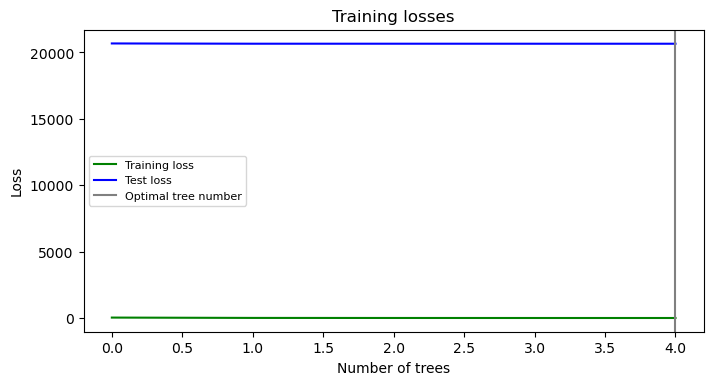

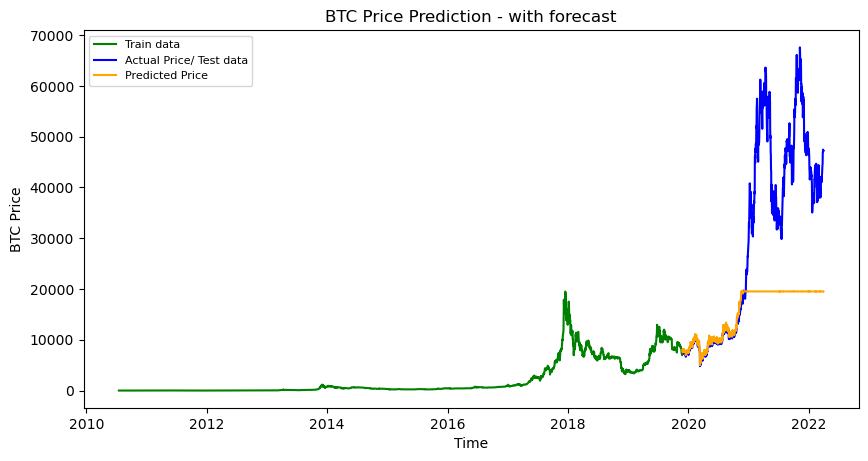

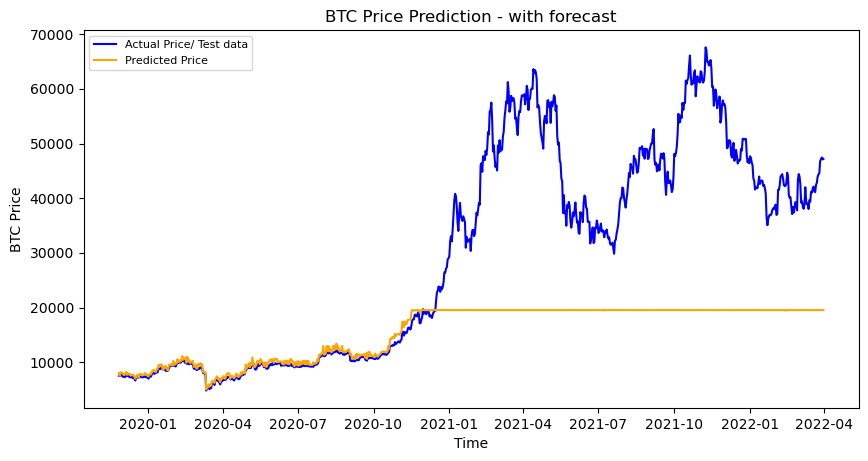

 33%|███▎      | 1/3 [29:49<59:39, 1789.51s/it]

XGBRegressor variant 1 : RMSE = 20658.384 


Data variant no: 2 

Length of X=1551, 
Length of y=1551

XGBRegressor fit, predict with GridSearchCV:

Best params:
 {'learning_rate': 1.2, 'max_depth': 10, 'min_child_weight': 1e-13, 'n_estimators': 5, 'reg_lambda': 1e-05}

Best estimator:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=1.2, max_delta_step=0,
             max_depth=10, min_child_weight=1e-13, missing=nan,
             monotone_constraints='()', n_estimators=5, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1e-05, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)
optimal trees: 2


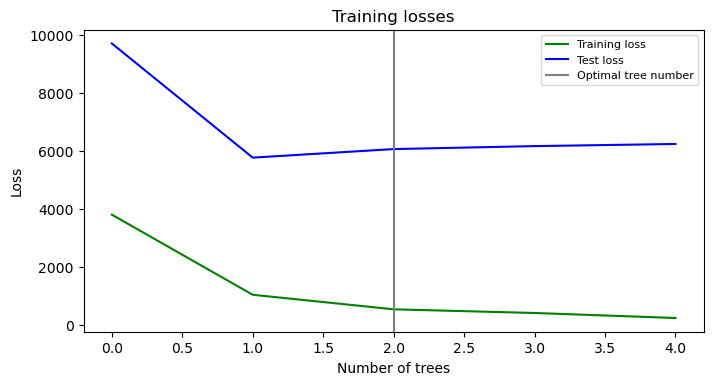

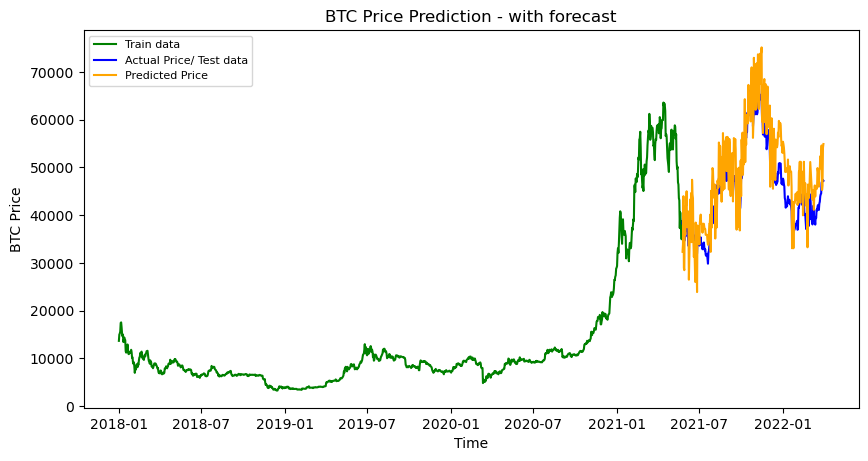

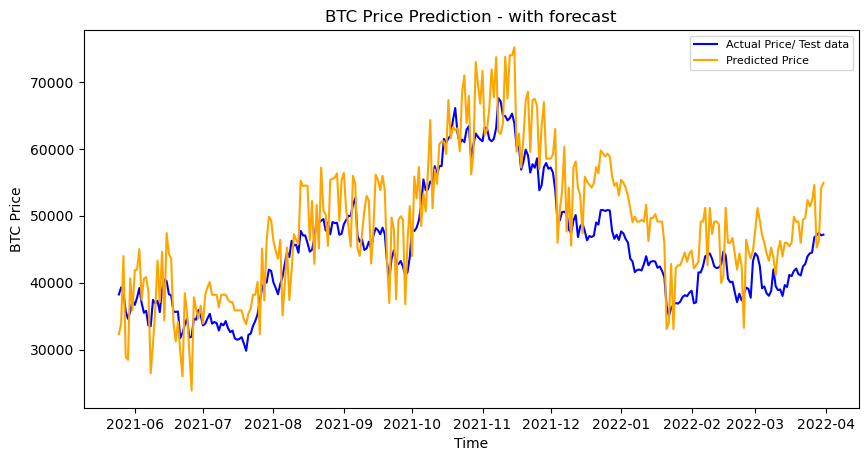

 67%|██████▋   | 2/3 [40:27<18:32, 1112.12s/it]

XGBRegressor variant 2 : RMSE = 5776.437 


Data variant no: 3 

Length of X=455, 
Length of y=455

XGBRegressor fit, predict with GridSearchCV:

Best params:
 {'learning_rate': 1.0, 'max_depth': 10, 'min_child_weight': 1e-13, 'n_estimators': 1, 'reg_lambda': 0.0001}

Best estimator:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=1.0, max_delta_step=0,
             max_depth=10, min_child_weight=1e-13, missing=nan,
             monotone_constraints='()', n_estimators=1, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.0001, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)
optimal trees: 1


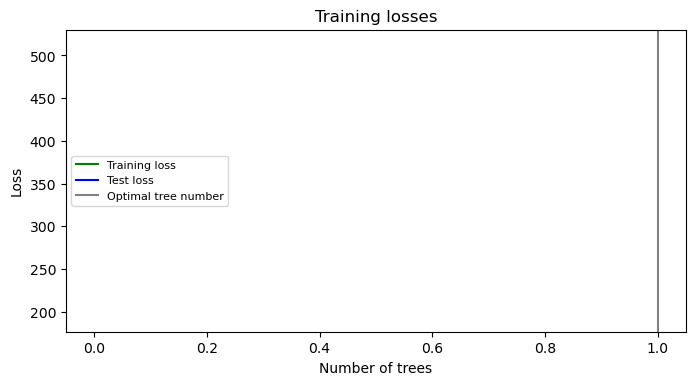

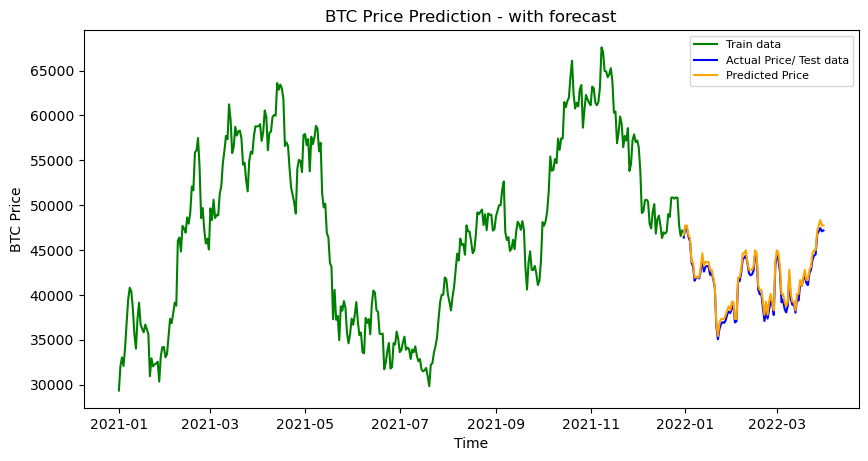

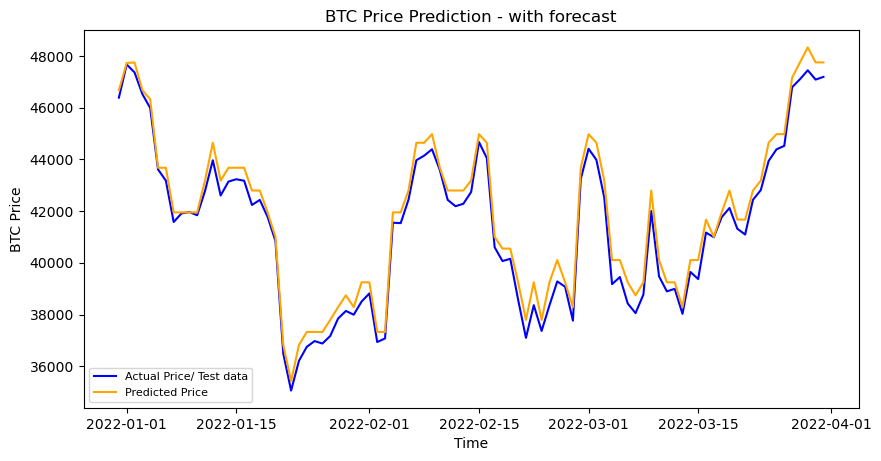

100%|██████████| 3/3 [46:08<00:00, 922.67s/it] 

XGBRegressor variant 3 : RMSE = 514.017 

Wall time: 46min 8s


In [11]:
%%time

# Forecasting
xgb_variant_rmse = xgbregressor_variants(df_variants=data_variants, train_size=0.8)

### 6.4. XGBRegressor  =>  summary

Prediction of Bitcoin Price based on historical data was performed with XGBRegressor model with GridSearchCV for getting optimal parameters.

- In first try, complete dataset was used to tran the model. There is too many data for given parameters of the model.

- In second try, dataset was sliced, started from 2018-01-01.

- In third try, dataset was sliced, started from 2021-01-01.

Every next optimalisation of pameters gave better reults and lower RMSE. Data set started from 2021-01-01 gave better result as for most recend data - better respresentation of current situation. 

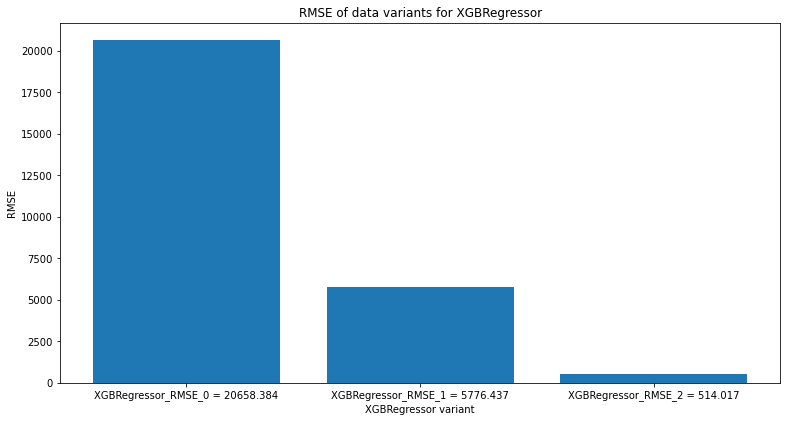

In [12]:
# plot for the RMSE's of data variants for XGBRegressor

XGBRegressor_variant = [("XGBRegressor_RMSE_" + str(x)) for x in range(len(xgb_variant_rmse))]
summary = []

for variant, result in zip(XGBRegressor_variant, xgb_variant_rmse):
    summary.append(variant + " = " + str(result))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(summary, xgb_variant_rmse)

plt.xlabel("XGBRegressor variant")
plt.ylabel("RMSE")
plt.title("RMSE of data variants for XGBRegressor")
plt.show()